In [9]:
import scipy
from scipy.io import mmread
import scanpy as sc
import anndata
import pandas as pd
import numpy as np

In [21]:
def calculate_optimal_PC(adata, min_PC = 50, min_var=25, n_comps=100, use_hv=None):
    'select number of PCs based on min_PC and min_var threshold'
    import matplotlib.pyplot as plt
    import scanpy as sc
    from kneed import KneeLocator

    #calculate PCs
    sc.tl.pca(adata, n_comps=100, zero_center=True, svd_solver='arpack', random_state=0, return_info=False, use_highly_variable=use_hv, dtype='float32', copy=False, chunked=False, chunk_size=None)
    sc.pl.pca_variance_ratio(adata, log=False)

    #calculate number of PCs

    a = adata.copy()# PCs kneepoint
    x = [i for i in range(len(a.uns["pca"]["variance_ratio"]))]
    y = list(a.uns["pca"]["variance_ratio"])
    kneedle = KneeLocator(x,
                      y,
                      S=1,
                      curve='convex',
                      direction='decreasing',
                      online=False)
    kn_pc = round(kneedle.knee, 3)
    kneedle.plot_knee()
    plt.show()
    kneedle.plot_knee_normalized()
    plt.show()
    print("Kneepoint happens at PC:", kn_pc)

    exp_var = sum(adata.uns['pca']['variance_ratio'][:kn_pc])
    exp_var_test_percent = exp_var*100
    print(kn_pc,'PC explain',exp_var_test_percent, '% of variance')

    #find number of PCs explaining at least min variance
    tested_PC_number = kn_pc



    tested_PC_number = 1
    while exp_var_test_percent <min_var:
        tested_PC_number = tested_PC_number+1
        exp_var_test = sum(adata.uns['pca']['variance_ratio'][0:tested_PC_number])
        exp_var_test_percent = exp_var_test*100
        print(tested_PC_number, 'PC explain',exp_var_test_percent, '% of variance')
        if tested_PC_number == n_comps:
            break

            
    exp_var_test = sum(adata.uns['pca']['variance_ratio'][0:min_PC])
    exp_var_test_percent = exp_var_test*100
    if tested_PC_number <min_PC:
        print('setting PCs to',min_PC)
        print('variance of',min_PC,'is',exp_var_test_percent,'%')
        tested_PC_number = min_PC
        
        
    #define PC number for embeddings
    number_of_PC_used = tested_PC_number
    
    exp_var_test = sum(adata.uns['pca']['variance_ratio'][0:tested_PC_number])
    exp_var_test_percent = exp_var_test*100
    print('number of PCs for clusterings/embeddings is:', number_of_PC_used)
    print('these explain', exp_var_test_percent,'of variance') 
    
    #recalculate PCs
    sc.pp.pca(adata, n_comps=number_of_PC_used, zero_center=True, svd_solver='arpack', random_state=0, return_info=False, use_highly_variable=use_hv, dtype='float32', copy=False, chunked=False, chunk_size=None)
    sc.pl.pca_variance_ratio(adata, log=False)
    return number_of_PC_used

In [6]:
DATA_DIR = '/home/wallet/Jupyter/TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8/matrix_files/'

In [65]:
#naive data
naive_matrix_path = DATA_DIR+'gene_sorted-naivedata_scp.mtx'
naive_barcodes_path = DATA_DIR+'naivedata_scp.barcodes.csv'
naive_genes_path = DATA_DIR+'naivedata_scp.genes.csv'
naive_annotations_path = DATA_DIR + 'combinenaivedata-reprocessed-clean-detailed-annotations.tsv'
naive_save_path = DATA_DIR + 'TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8-X-naive.h5ad'
#treated data
treated_matrix_path = DATA_DIR+'gene_sorted-treated_data_scp.mtx'
treated_barcodes_path = DATA_DIR+'treateddata_scp.barcodes.csv'
treated_genes_path = DATA_DIR+'treateddata_scp.genes.csv'
treated_annotations_path = DATA_DIR + 'combinetreateddata-reprocessed-final-annotations.tsv'
treated_save_path = DATA_DIR + 'TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8-X-treated.h5ad'


adata_save_path = DATA_DIR + 'TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8-X-all_cells.h5ad'

# get naive data

In [4]:
naive_matrix = mmread(naive_matrix_path)
naive_matrix

<22164x88031 sparse matrix of type '<class 'numpy.float64'>'
	with 151832488 stored elements in COOrdinate format>

In [5]:
#get file encoding
!file -bi {naive_barcodes_path}

application/gzip; charset=binary


In [6]:
naive_barcodes = pd.read_csv(naive_barcodes_path, compression='gzip')
del naive_barcodes['Unnamed: 0']
naive_barcodes.columns = ['barcodes']
naive_barcodes = naive_barcodes.set_index('barcodes')
naive_barcodes

""
barcodes
AAACCTGTCTGGTTCC-1-0
AAACGGGTCCTTTCTC-1-0
AAACGGGTCTAACCGA-1-0
AAAGATGCAATGGACG-1-0
AAAGATGCACGGCTAC-1-0
...
TTTGGTTCATGTGACT-1-14
TTTGGTTGTGAGACCA-1-14
TTTGGTTTCCAGCCTT-1-14


In [7]:
naive_genes = pd.read_csv(naive_genes_path,header=None)
naive_genes.columns= ['gene_names']
naive_genes['gene_names'] = naive_genes['gene_names'].astype(str)
naive_genes = naive_genes.set_index('gene_names')
naive_genes

""
gene_names
FAM138A
OR4F5
OR4F29
OR4F16
FAM87B
...
AC004556.1
AC233755.2
AC233755.1


In [8]:
naive_annotations = pd.read_csv(naive_annotations_path,sep='\t')
naive_annotations = naive_annotations.drop(index=[0])
naive_annotations = naive_annotations.set_index('NAME')
naive_annotations

,cell_subsets,pid,n_genes
NAME,,,
AAACCTGTCTGGTTCC-1-0,Tumor,003_10x,767
AAACGGGTCCTTTCTC-1-0,Tumor,003_10x,603
AAACGGGTCTAACCGA-1-0,Fibroblast,003_10x,910
AAAGATGCAATGGACG-1-0,Tumor,003_10x,893
AAAGATGCACGGCTAC-1-0,Endothelial,003_10x,765
...,...,...,...
TTTGGTTCATGTGACT-1-14,Endothelial,2664_10x,1037
TTTGGTTGTGAGACCA-1-14,Tumor,2664_10x,1839
TTTGGTTTCCAGCCTT-1-14,Tumor,2664_10x,1793


In [9]:
#transform to dicts
naive_celltype_dict = naive_annotations['cell_subsets'].to_dict()
naive_pid_dict = naive_annotations['pid'].to_dict()
naive_ngenes_dict = naive_annotations['n_genes'].to_dict()

In [19]:
naive_matrix_dense = np.array(naive_matrix.T.todense())

In [26]:
from scipy.sparse import csr_matrix
adata_naive = anndata.AnnData(X=csr_matrix(naive_matrix.T), obs=naive_barcodes, var=naive_genes, uns=None, obsm=None, varm=None, layers=None, raw=None, 
                              shape=None, filename=None, filemode=None, asview=False, obsp=None, varp=None, 
                              oidx=None, vidx=None)
adata_naive

AnnData object with n_obs × n_vars = 88031 × 22164

In [27]:
adata_naive.obs['cell_subsets'] = pd.Categorical(adata_naive.obs_names.map(naive_celltype_dict).astype(str))
adata_naive.obs['pid'] = pd.Categorical(adata_naive.obs_names.map(naive_pid_dict).astype(str))
adata_naive.obs['n_genes'] = adata_naive.obs_names.map(naive_ngenes_dict).astype(int)
adata_naive.obs

,cell_subsets,pid,n_genes
barcodes,,,
AAACCTGTCTGGTTCC-1-0,Tumor,003_10x,767
AAACGGGTCCTTTCTC-1-0,Tumor,003_10x,603
AAACGGGTCTAACCGA-1-0,Fibroblast,003_10x,910
AAAGATGCAATGGACG-1-0,Tumor,003_10x,893
AAAGATGCACGGCTAC-1-0,Endothelial,003_10x,765
...,...,...,...
TTTGGTTCATGTGACT-1-14,Endothelial,2664_10x,1037
TTTGGTTGTGAGACCA-1-14,Tumor,2664_10x,1839
TTTGGTTTCCAGCCTT-1-14,Tumor,2664_10x,1793


In [28]:
adata_naive.X

<88031x22164 sparse matrix of type '<class 'numpy.float64'>'
	with 151832488 stored elements in Compressed Sparse Row format>

In [29]:
set(adata_naive.obs['cell_subsets'])

{'Acinar',
 'Atypical_Ductal',
 'Ductal',
 'Endocrine',
 'Endothelial',
 'Fibroblast',
 'Immune',
 'NascentEndothelial',
 'Schwann',
 'SmoothMuscle',
 'Tumor'}

In [30]:
naive_save_path

'/home/wallet/Jupyter/TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8/matrix_files/TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8-X-naive.h5ad'

In [31]:
adata_naive.write(naive_save_path)
print('saved to:',naive_save_path)

saved to: /home/wallet/Jupyter/TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8/matrix_files/TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8-X-naive.h5ad


# get treated data

In [33]:
treated_matrix = mmread(treated_matrix_path)
treated_matrix

<22164x50516 sparse matrix of type '<class 'numpy.float64'>'
	with 77627464 stored elements in COOrdinate format>

In [34]:
treated_matrix = csr_matrix(treated_matrix.T)

In [35]:
#get file encoding
!file -bi {treated_barcodes_path}

text/plain; charset=us-ascii


In [39]:
treated_barcodes

,AAACCCAAGCAGCAGT-1-0
0,AAACCCAAGTGGTTCT-1-0
1,AAACCCACATTGTCGA-1-0
2,AAACCCAGTTGACTGT-1-0
3,AAACGAAAGTTGGAGC-1-0
4,AAACGAACATGGAGAC-1-0
...,...
50510,TTTGTCATCCATGAGT-1-10
50511,TTTGTCATCCGTTGTC-1-10
50512,TTTGTCATCTACTATC-1-10
50513,TTTGTCATCTAGCACA-1-10


In [40]:
treated_barcodes = pd.read_csv(treated_barcodes_path,header=None)
treated_barcodes.columns = ['barcodes']
treated_barcodes = treated_barcodes.set_index('barcodes')
treated_barcodes

""
barcodes
AAACCCAAGCAGCAGT-1-0
AAACCCAAGTGGTTCT-1-0
AAACCCACATTGTCGA-1-0
AAACCCAGTTGACTGT-1-0
AAACGAAAGTTGGAGC-1-0
...
TTTGTCATCCATGAGT-1-10
TTTGTCATCCGTTGTC-1-10
TTTGTCATCTACTATC-1-10


In [50]:
treated_genes = pd.read_csv(treated_genes_path,header=None)
treated_genes.columns = ['gene_names']
treated_genes['gene_names'] = treated_genes['gene_names'].astype(str)
treated_genes = treated_genes.set_index('gene_names')
treated_genes

""
gene_names
FAM138A
OR4F5
OR4F29
OR4F16
FAM87B
...
AC233755.2
AC233755.1
AC240274.1


In [51]:
treated_annotations = pd.read_csv(treated_annotations_path,sep='\t')
treated_annotations = treated_annotations.drop(index=[0])
treated_annotations = treated_annotations.set_index('NAME')
treated_annotations

,cell_subsets,pid,n_genes
NAME,,,
AAACCCAAGCAGCAGT-1-0,Fibroblast,008_10x,2444
AAACCCAAGTGGTTCT-1-0,Ductal,008_10x,6044
AAACCCACATTGTCGA-1-0,Endothelial,008_10x,5152
AAACCCAGTTGACTGT-1-0,Endocrine,008_10x,2603
AAACGAAAGTTGGAGC-1-0,Ductal,008_10x,2156
...,...,...,...
TTTGTCATCCATGAGT-1-10,Fibroblast,2668_10x,493
TTTGTCATCCGTTGTC-1-10,Endocrine,2668_10x,795
TTTGTCATCTACTATC-1-10,Fibroblast,2668_10x,623


In [52]:
#transform to dicts
treated_celltype_dict = treated_annotations['cell_subsets'].to_dict()
treated_pid_dict = treated_annotations['pid'].to_dict()
treated_ngenes_dict = treated_annotations['n_genes'].to_dict()

In [53]:
adata_treated = anndata.AnnData(X=treated_matrix, obs=treated_barcodes, var=treated_genes, uns=None, obsm=None, varm=None, layers=None, raw=None, 
                              shape=None, filename=None, filemode=None, asview=False, obsp=None, varp=None, 
                              oidx=None, vidx=None)
adata_treated

AnnData object with n_obs × n_vars = 50516 × 22164

In [57]:
adata_treated.obs['cell_subsets'] = pd.Categorical(adata_treated.obs_names.map(treated_celltype_dict).astype(str))
adata_treated.obs['pid'] = pd.Categorical(adata_treated.obs_names.map(treated_pid_dict).astype(str))
adata_treated.obs['n_genes'] = adata_treated.obs_names.map(treated_ngenes_dict).astype(int)
adata_treated.obs

,cell_subsets,pid,n_genes
barcodes,,,
AAACCCAAGCAGCAGT-1-0,Fibroblast,008_10x,2444
AAACCCAAGTGGTTCT-1-0,Ductal,008_10x,6044
AAACCCACATTGTCGA-1-0,Endothelial,008_10x,5152
AAACCCAGTTGACTGT-1-0,Endocrine,008_10x,2603
AAACGAAAGTTGGAGC-1-0,Ductal,008_10x,2156
...,...,...,...
TTTGTCATCCATGAGT-1-10,Fibroblast,2668_10x,493
TTTGTCATCCGTTGTC-1-10,Endocrine,2668_10x,795
TTTGTCATCTACTATC-1-10,Fibroblast,2668_10x,623


In [58]:
adata_treated.write(treated_save_path)
print('saved to:',treated_save_path)

saved to: /home/wallet/Jupyter/TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8/matrix_files/TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8-X-treated.h5ad


In [60]:
adata_treated.obs['treated'] = ['True']*len(adata_treated)
adata_treated.obs['treated'] =pd.Categorical(adata_treated.obs['treated'])
adata_naive.obs['treated'] = ['False']*len(adata_naive)
adata_naive.obs['treated'] =pd.Categorical(adata_naive.obs['treated'])


In [63]:
#concatenate adatas
adata = adata_naive.concatenate([adata_treated],join='outer', batch_key='treated', batch_categories=['untreated','treated'], 
                            uns_merge=None, index_unique='-', fill_value=None)

/home/wallet/miniconda3/envs/2023_sc_pytorch/lib/python3.10/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [71]:
adata

AnnData object with n_obs × n_vars = 138547 × 22164
    obs: 'cell_subsets', 'pid', 'n_genes', 'treated'

In [70]:
adata.write(adata_save_path)
print('saved to:',adata_save_path)

saved to: /home/wallet/Jupyter/TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8/matrix_files/TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8-X-all_cells.h5ad


# explore data

In [7]:
adata_path  = DATA_DIR + 'TIL-X-PDAC-X-snRNAseq-X-2022-X-Hwang-X-10.1038_s41588-022-01134-8-X-all_cells.h5ad'

In [17]:
adata = sc.read(adata_path)
adata

AnnData object with n_obs × n_vars = 138547 × 22164
    obs: 'cell_subsets', 'pid', 'n_genes', 'treated'

In [18]:
adata

AnnData object with n_obs × n_vars = 138547 × 22164
    obs: 'cell_subsets', 'pid', 'n_genes', 'treated'

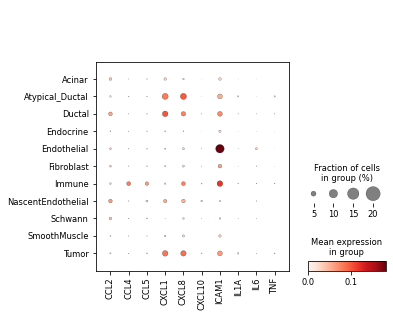

In [23]:
markers = ['CCL2', 'CCL4', 'CCL5', 'CXCL1', 'CXCL8', 'CXCL10','ICAM1',
           'IL1A','IL6','TNF']
markers_clean = [x for x in markers if x in adata.var_names]
sc.pl.dotplot(adata, markers_clean, groupby='cell_subsets', dendrogram=False)

In [27]:
import cytopus as cp

In [29]:
G = cp.kb.KnowledgeBase()
G

KnowledgeBase object containing 75 cell types and 201 cellular processes



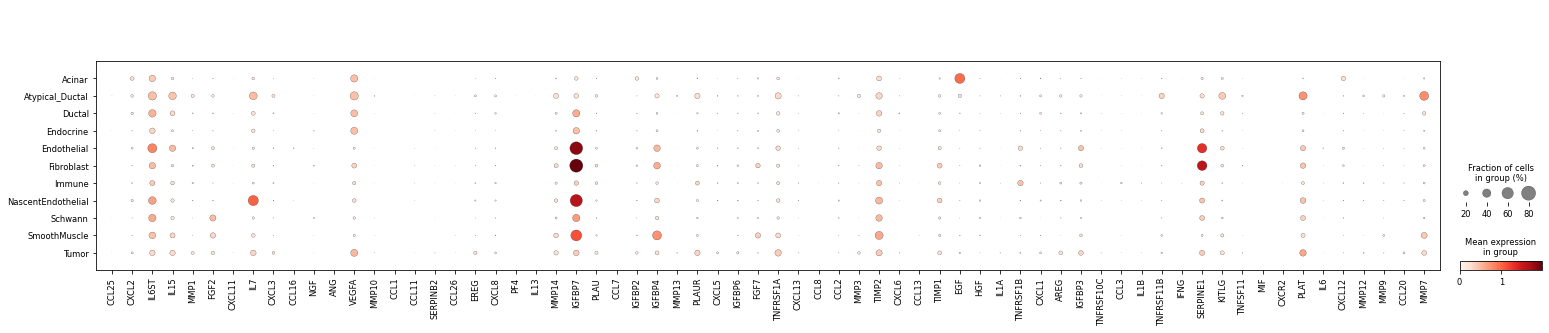

In [33]:
markers = list(G.processes['all_SASP'])
markers_clean = [x for x in markers if x in adata.var_names]
sc.pl.dotplot(adata, markers_clean, groupby='cell_subsets', dendrogram=False)

In [37]:
print(adata.X)

  (0, 12324)	4.38658
  (0, 12328)	3.7057991
  (0, 12329)	2.3906541
  (0, 12327)	3.9240142999999996
  (0, 12323)	4.7878885
  (0, 12319)	3.7057991
  (0, 12322)	4.2548242
  (0, 12321)	5.0093646
  (0, 12326)	3.4262772000000004
  (0, 12325)	4.1030369
  (0, 5087)	2.3906541
  (0, 4173)	2.3906541
  (0, 19080)	3.4262772000000004
  (0, 2030)	2.3906541
  (0, 8101)	2.3906541
  (0, 18009)	3.0369351000000004
  (0, 16818)	2.3906541
  (0, 2288)	2.3906541
  (0, 19689)	3.0369351000000004
  (0, 19411)	2.3906541
  (0, 11556)	2.3906541
  (0, 2182)	2.3906541
  (0, 16505)	3.0369351000000004
  (0, 5867)	2.3906541
  (0, 16081)	2.3906541
  :	:
  (138546, 5286)	2.1219667999999996
  (138546, 12892)	2.1219667999999996
  (138546, 18344)	2.1219667999999996
  (138546, 13211)	2.1219667999999996
  (138546, 13904)	2.1219667999999996
  (138546, 5864)	2.1219667999999996
  (138546, 6081)	2.1219667999999996
  (138546, 11614)	2.1219667999999996
  (138546, 3154)	2.1219667999999996
  (138546, 21280)	2.1219667999999996
  (13854

In [ ]:
#define minimum number of cells per gene and minimum genes per cell
min_cell_number = 20
min_gene_number = 200